#  CSTR fault detection

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(-0.5, 1096.5, 551.5, -0.5)

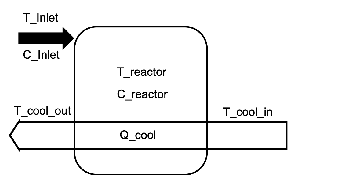

In [2]:
cstr= mpimg.imread('cstr.png')
plt.imshow(cstr)
plt.axis('off')

#  data collection and clean the data

In [3]:
## Import data
mat = scipy.io.loadmat('cstr_fault_time_series.mat')
## make data into pandas 
fault_label=mat["fault_labels"].flatten()
data = pd.DataFrame({'C_inlet':mat["data"][:, 0], 'T_inlet':mat["data"][:, 1] \
                     ,'C_reactor':mat["data"][:, 2], 'T_reactor':mat["data"][:, 3] \
                     ,'Q_cool':mat["data"][:, 4], 'T_cool_in':mat["data"][:, 5]\
                     ,'T_cool_out':mat["data"][:, 6],'fault':fault_label
                    
                    })
## calculate the heat transfer amount
data['heat']=data['Q_cool']*(data['T_cool_out']-data['T_cool_in'])
data = data[["C_inlet","C_reactor","Q_cool","T_cool_in","T_cool_out",\
             "T_inlet","T_reactor","heat","fault"]]
## show the head of data
data.head()

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,heat,fault
0,1.027647,0.099224,148.841248,348.638761,416.686204,350.360361,430.879667,10128.266233,0
1,1.027779,0.094646,157.013774,348.713451,417.987404,350.299300,432.911189,10876.964729,0
2,1.026808,0.108838,154.560242,349.188551,414.600037,349.971868,429.661746,10110.015071,0
3,1.026215,0.097684,157.220063,348.729069,416.656083,350.640629,432.256645,10679.489263,0
4,1.026132,0.100689,162.379105,348.849656,416.179071,350.595431,431.304828,10932.890056,0


In [4]:
## seperte  based on fault
normal=data[data['fault']==0]
normal = normal.drop('fault', 1)
## fault 1
f1=data[data['fault']==1]
f1=f1.drop('fault', 1)
## fault 2
f2=data[data['fault']==2]
f2=f2.drop('fault', 1)
## fault 3
f3=data[data['fault']==3]
f3=f3.drop('fault', 1)
## fault 4
f4=data[data['fault']==4]
f4=f4.drop('fault', 1)
## fault 5
f5=data[data['fault']==5]
f5=f5.drop('fault', 1)

# Have  a feeling of what normal data look like

In [5]:
### calculate the correacloation
corr = normal.corr()
corr.style.background_gradient(cmap=cm.plasma)

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,heat
C_inlet,1,0.337727,0.865872,-0.103169,-0.430025,-0.14273,0.0325988,0.790347
C_reactor,0.337727,1,0.160318,-0.0381804,-0.958128,-0.0298583,-0.904093,-0.163197
Q_cool,0.865872,0.160318,1,0.143554,-0.30809,0.0522386,0.19717,0.915468
T_cool_in,-0.103169,-0.0381804,0.143554,1,0.0407638,0.0529842,-0.00447289,-0.0825254
T_cool_out,-0.430025,-0.958128,-0.30809,0.0407638,1,-0.0336354,0.85825,0.0189059
T_inlet,-0.14273,-0.0298583,0.0522386,0.0529842,-0.0336354,1,-0.0174267,0.0301891
T_reactor,0.0325988,-0.904093,0.19717,-0.00447289,0.85825,-0.0174267,1,0.516496
heat,0.790347,-0.163197,0.915468,-0.0825254,0.0189059,0.0301891,0.516496,1


/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:400: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


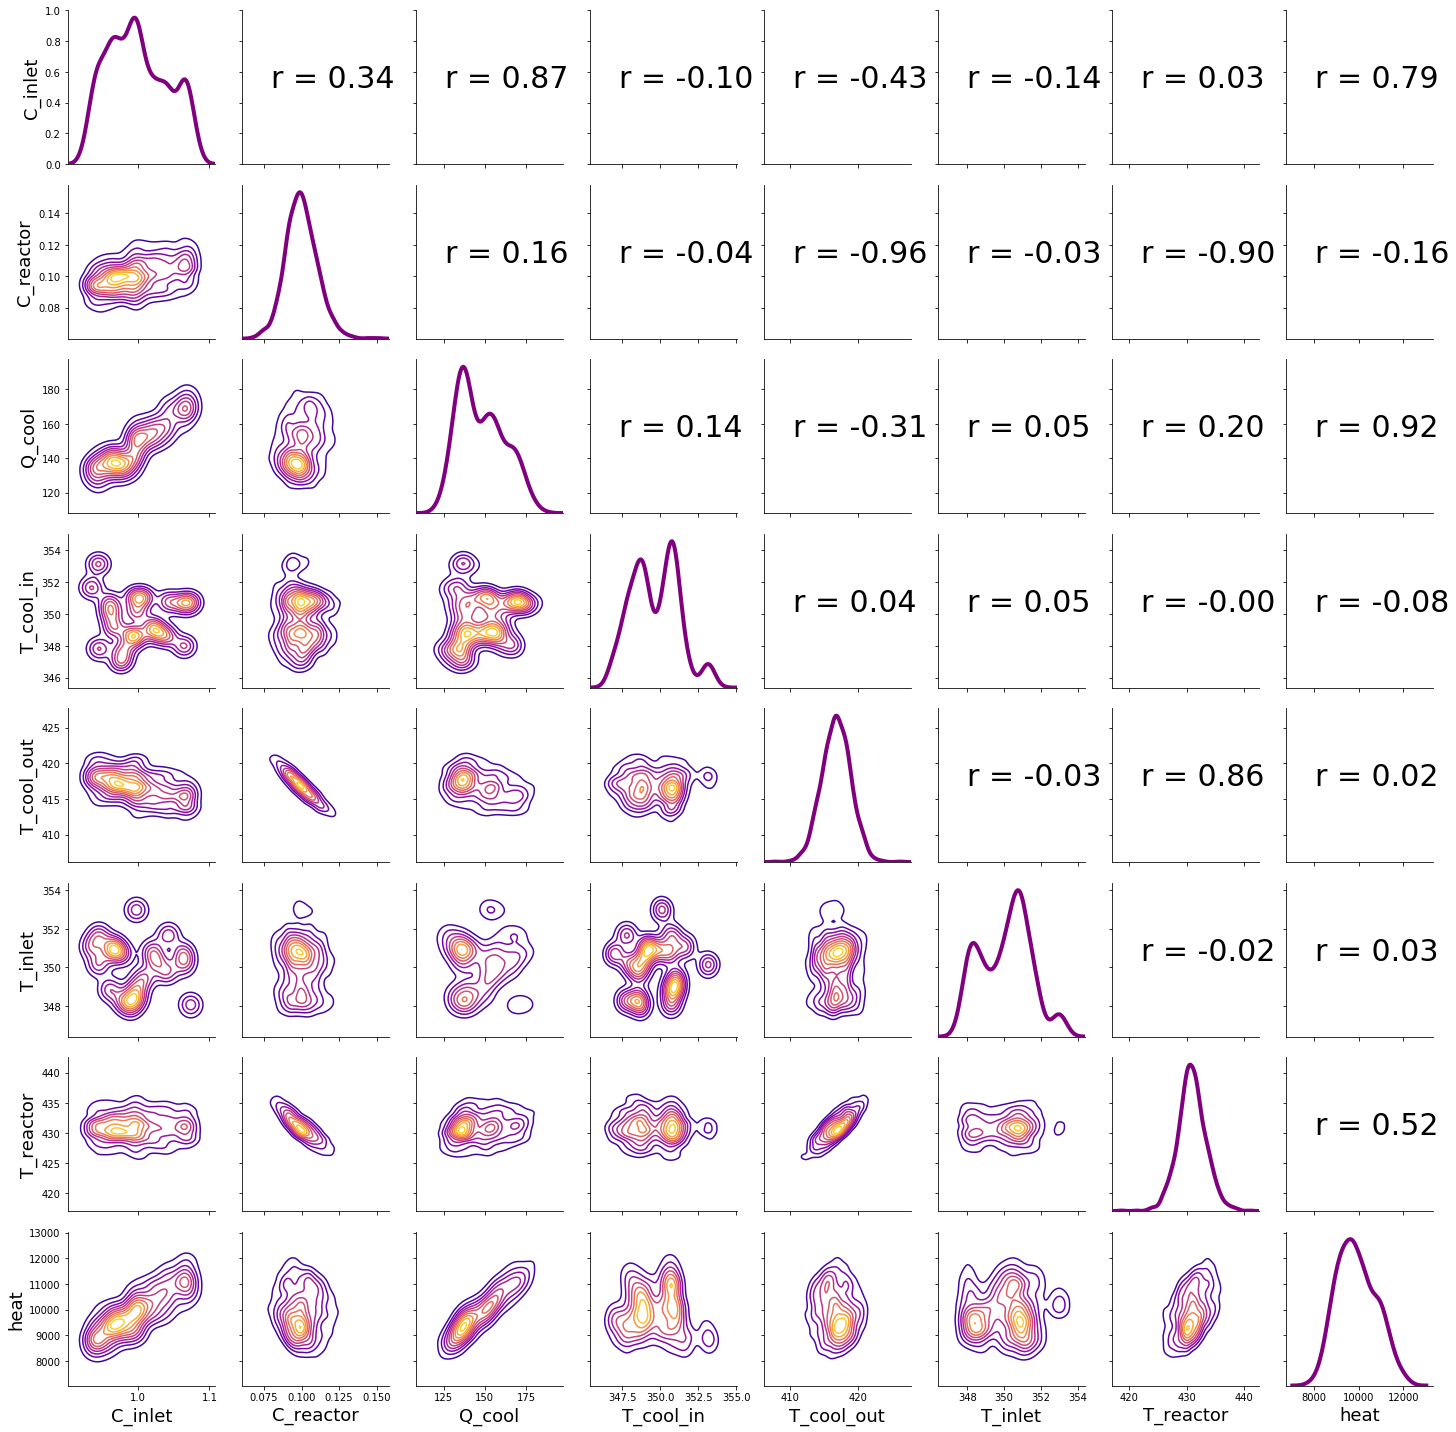

In [56]:
### plot the correacloation
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    text=ax.annotate("r = {:.2f}".format(r), xy=(.2, .5), xycoords=ax.transAxes)
    text.set_fontsize(30)
    
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(normal, diag_sharey=False)
axes = g.axes
#g.map_upper(matplotlib.pyplot.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_diag(sns.kdeplot, lw = 4, legend=False,color="purple")
g.map_lower(sns.kdeplot, cmap=cm.plasma)
g.map_upper(corrfunc)
matplotlib.pyplot.show()


# Feature selection 

In [9]:
#1 method1 
from sklearn.ensemble import ExtraTreesClassifier
array=data.values

X = array[:,0:8]
X=StandardScaler().fit_transform(X)
Y = array[:,8]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)



[0.17251688 0.02232461 0.13769297 0.03465262 0.02493117 0.39851713
 0.01341308 0.19595155]


Optimal number of features : 3


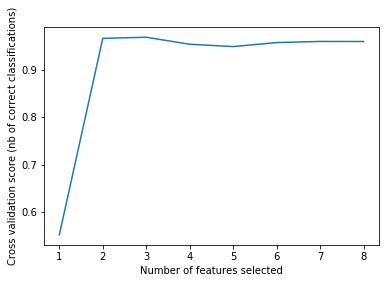

['C_inlet', 'T_inlet', 'Q_cool', 'C_reactor', 'T_cool_in', 'heat', 'T_cool_out', 'T_reactor']


In [10]:
#2 method 2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
# Create the RFE object and rank each pixel
svc =  SVC(kernel="linear", C=1)

rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, Y)
ranking = rfe.ranking_
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print([x for _,x in sorted(zip(ranking,list(data.columns.values)))])

# nertral network

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


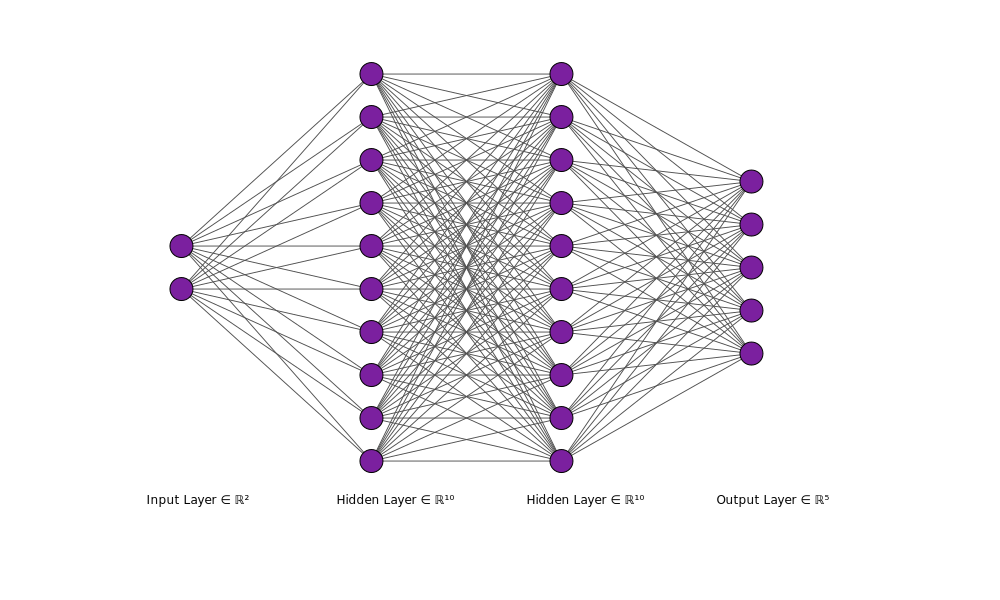

In [14]:
from IPython.display import SVG
SVG('ANN.svg')

In [15]:
datasets = [data[["C_inlet","T_inlet"]].values,np.ndarray.flatten(data[["fault"]].values)
            ]
X,y=datasets
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#softmax,'rmsprop
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='softmax'))   # Final Layer using Softmax
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
Y_train = keras.utils.to_categorical(y_train, num_classes=6)
Y_test = keras.utils.to_categorical(y_test, num_classes=6)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=64)
score = model.evaluate(X_test, Y_test, batch_size=64)

Epoch 1/20
5764/5764 [==============================] - 0s 52us/sample - loss: 1.0219 - accuracy: 0.6546
Epoch 2/20
5764/5764 [==============================] - 0s 14us/sample - loss: 0.2865 - accuracy: 0.9313
Epoch 3/20
5764/5764 [==============================] - 0s 14us/sample - loss: 0.1788 - accuracy: 0.9478
Epoch 4/20
5764/5764 [==============================] - 0s 14us/sample - loss: 0.1387 - accuracy: 0.9535
Epoch 5/20
5764/5764 [==============================] - 0s 14us/sample - loss: 0.1166 - accuracy: 0.9565
Epoch 6/20
5764/5764 [==============================] - 0s 13us/sample - loss: 0.0988 - accuracy: 0.9608
Epoch 7/20
5764/5764 [==============================] - 0s 13us/sample - loss: 0.0857 - accuracy: 0.9679
Epoch 8/20
5764/5764 [==============================] - 0s 13us/sample - loss: 0.0774 - accuracy: 0.9722
Epoch 9/20
5764/5764 [==============================] - 0s 13us/sample - loss: 0.0700 - accuracy: 0.9776
Epoch 10/20
5764/5764 [==============================] 

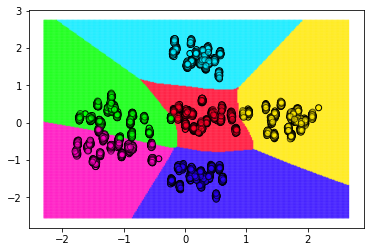

In [19]:
h=0.02
x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
x0, x1 = np.meshgrid(np.arange(x0_min, x0_max, h),np.arange(x1_min, x1_max, h))
prediction = model.predict(np.c_[x0.ravel(), x1.ravel()])
z=np.argmax(prediction, axis=1)
z = z.reshape(x0.shape)
plt.scatter(x0.ravel(), x1.ravel(), c=z.ravel(), cmap=cm.gist_rainbow, alpha=.8,s=0.2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm.gist_rainbow,
               edgecolors='k')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.gist_rainbow,
               edgecolors='k', alpha=0.6)

# Other method

In [20]:
### classfication 
from matplotlib.colors import ListedColormap


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score


In [27]:

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=int(np.sqrt(5))),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
     QuadraticDiscriminantAnalysis()]
datasets = [data[["C_inlet","T_inlet"]].values,np.ndarray.flatten(data[["fault"]].values)
            ]

In [28]:
h=0.02
X,y=datasets
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
  

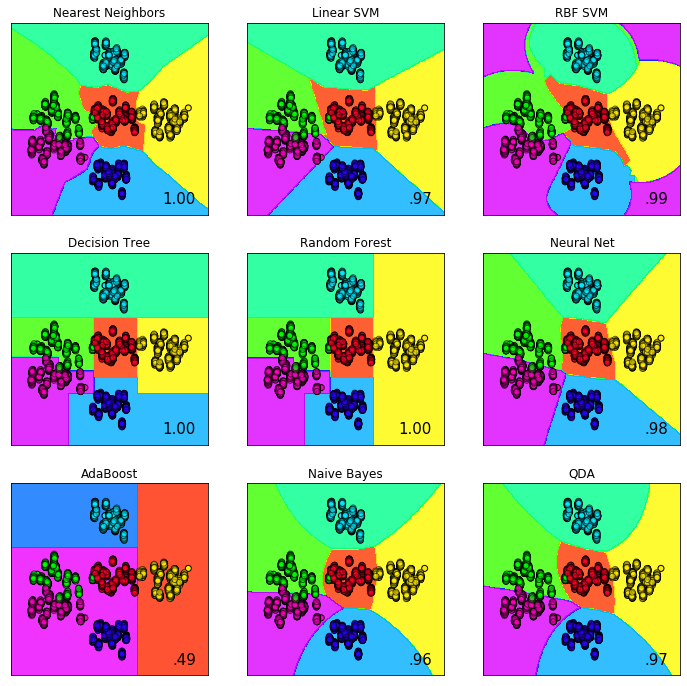

In [30]:
figure = plt.figure(figsize=( 12,12 ))
i = 1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(3,3, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    #if hasattr(clf, "decision_function"):
     #   Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    #else:
     #   Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 5]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm.gist_rainbow, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm.gist_rainbow,
               edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.gist_rainbow,
               edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    i=i+1
       
#plt.tight_layout()
#plt.show()